# Linear Regression Analysis
Sufian Adnan


## Task 1: Understand the Data

### Objective

Analyze the dataset, create visualizations, and prepare the data for regression analysis.

### Entry Points

1. Read the CSV file into a DataFrame.
2. Generate different types of plots (line, bar, scatter) to describe the data.
3. Convert non-numeric columns into numeric values.
4. Split the data into training and testing sets.


In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

In [17]:
data_file = "Dataset.csv"
df = pd.read_csv(data_file)

# Display the first few rows of the dataset to understand its structure
print(df.head())

# Check the information and data types of columns
print(df.info())

# Check for missing values in the dataset
print(df.isnull().sum())

         Date                               Name Country BusinessType  \
0   1/10/2000                        CD Universe      US          Biz   
1  11/14/2000                      Western Union      US          Biz   
2  11/15/2000                   Contour Software      US          Biz   
3  11/15/2000                        Travelocity      US          Biz   
4   12/9/2000  University of Washington Med Ctr.      US          Edu   

  BusinessSubType BreachType DataType DataType2        InsideOutside  \
0          Retail       Hack      CCN         ?              Outside   
1             Fin       Hack      CCN         ?              Outside   
2            Tech        Web      SSN         ?  Inside - Accidental   
3          Retail        Web      NAA         ?  Inside - Accidental   
4             Med       Hack      SSN       NAA              Outside   

  ThirdParty ThirdPartyName TotalAffected  \
0         No            NaN        300000   
1         No            NaN         15

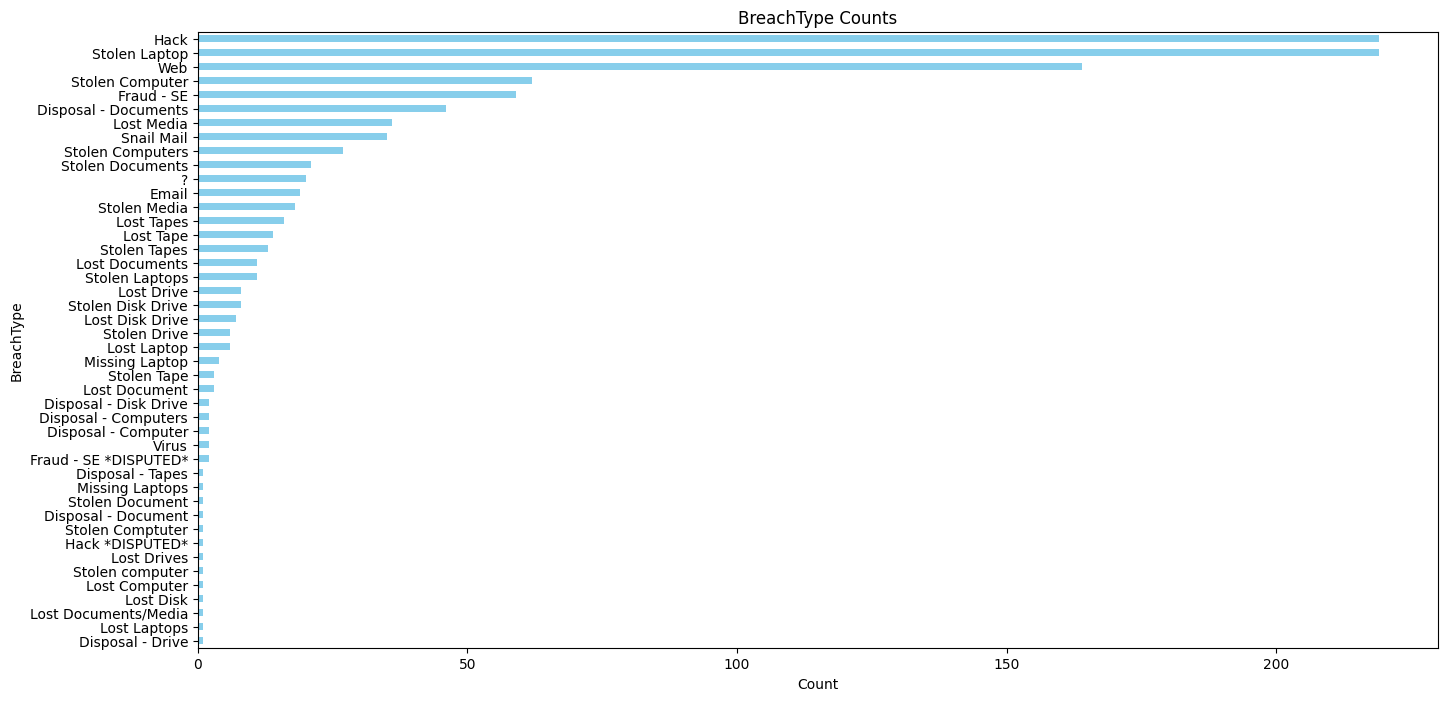

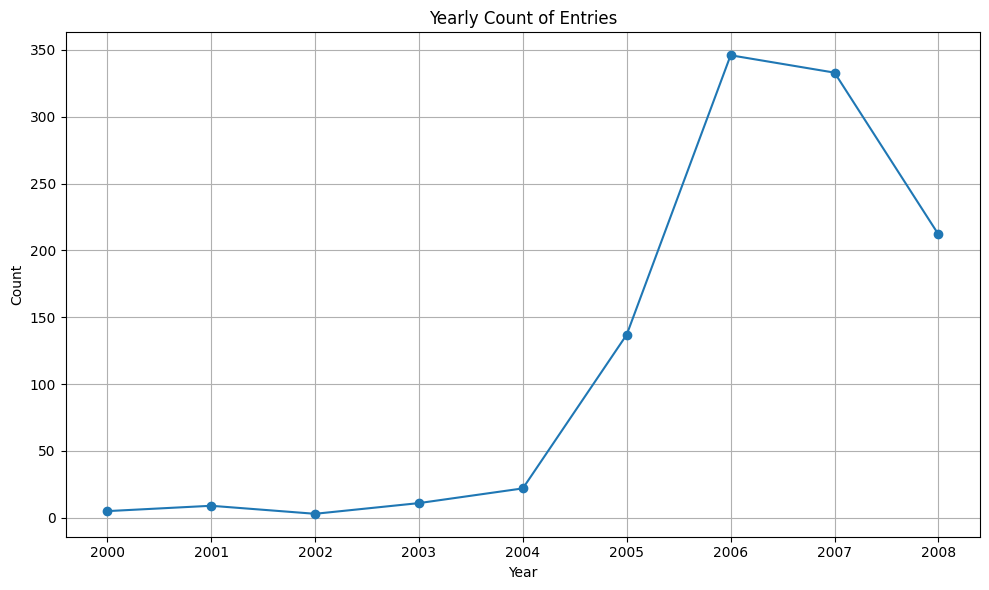

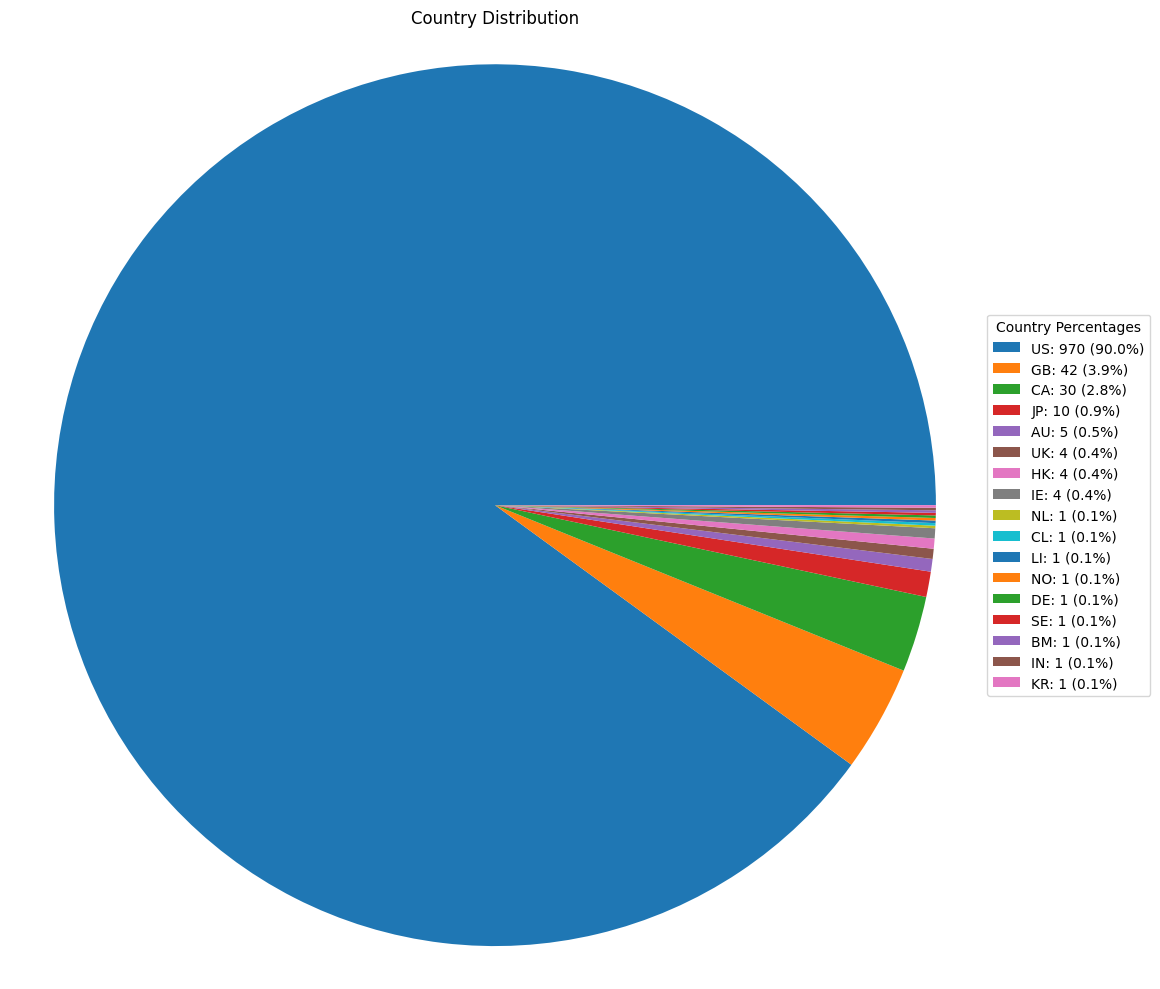

<Figure size 1200x600 with 0 Axes>

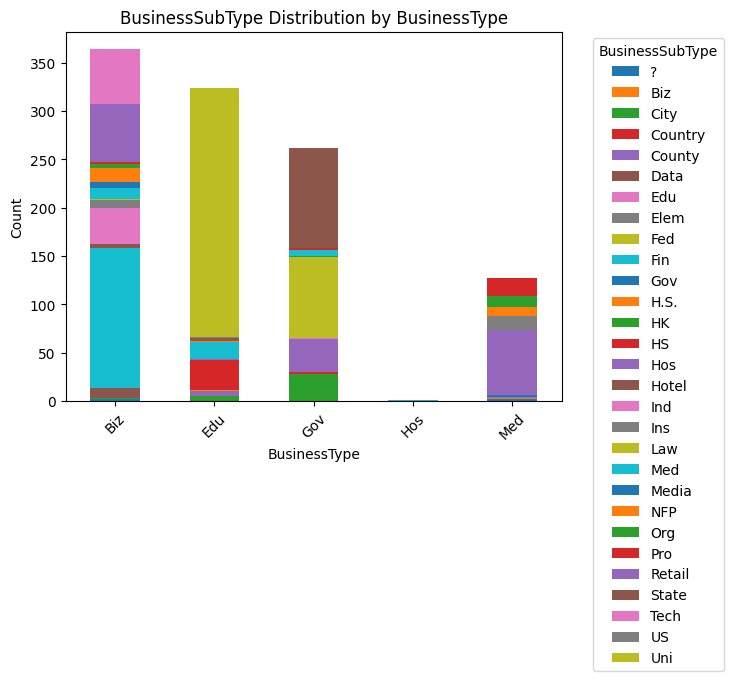

In [18]:
# Plotting a bar chart for 'BreachType' counts
plt.figure(figsize=(16, 8))
counts = df['BreachType'].value_counts()
counts.plot(kind='barh', color='skyblue')
plt.title('BreachType Counts')
plt.xlabel('Count')
plt.ylabel('BreachType')
plt.gca().invert_yaxis()
plt.show()

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extracting the year from the Date column
df['Year'] = df['Date'].dt.year

# Count occurrences of entries per year
yearly_counts = df['Year'].value_counts().sort_index()

# Plotting yearly counts as a line graph
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linestyle='-')
plt.title('Yearly Count of Entries')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(yearly_counts.index)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
country_counts = df['Country'].value_counts()
pie_chart = country_counts.plot(kind='pie', autopct='', labels=None)
plt.title('Country Distribution')
plt.ylabel('')
plt.tight_layout()

# Creating a custom legend with country names and percentages
legend_labels = [f'{country}: {count} ({percentage:.1f}%)' for country, count, percentage in zip(
    country_counts.index, country_counts.values, country_counts.values / country_counts.sum() * 100)]
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(
    1, 0, 0.5, 1), title='Country Percentages')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()


# Count of BusinessSubType within each BusinessType
subtype_counts = df.groupby(['BusinessType', 'BusinessSubType']).size().unstack()

# Plotting a stacked bar plot
plt.figure(figsize=(12, 6))
subtype_counts.plot(kind='bar', stacked=True)
plt.title('BusinessSubType Distribution by BusinessType')
plt.xlabel('BusinessType')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='BusinessSubType', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()


## Task 2: Simple Linear Regression

### Objective

Perform simple linear regression and assess model accuracy.

### Entry Points

1. Select independent and dependent variables.
2. Create a linear regression model using scikit-learn.
3. Calculate coefficients of determination, RMSE, intercept, and slope.
4. Predict values for training and test datasets.
5. Compare predicted vs. actual values and plot the results.
---

### Automated Best Model Selection using Linear Regression

1. **Data Preprocessing:**
    - Drops non-numeric columns (`'Date'`, `'Name'`, `'Country'`, `'RefPage'`, `'UID'`, `'XREF1'`, `'StockSymbol'`) from the dataset (`df`).

2. **Categorical Variables Handling:**
    - Converts categorical variables into numerical values using label encoding.
    - Identifies categorical columns and applies category codes to convert them to numerical representation.

3. **Model Building and Selection:**
    - Initializes variables to store the best model's information (`best_r2` and `best_model_info`).
    - Iterates through combinations of independent and dependent variables in the dataset.

4. **Linear Regression Model Fitting:**
    - For each combination of independent (`independent_var`) and dependent (`dependent_var`) variables:
        - Splits the dataset into training and testing sets with a 70-30 split ratio.
        - Initializes and fits a Linear Regression model using `LinearRegression()` from `sklearn.linear_model`.
        - Calculates R-squared scores (`train_r2` and `test_r2`) and RMSE (`train_rmse` and `test_rmse`) for training and testing sets.
        - Retrieves intercept and slope values for the linear regression model.

5. **Best Model Selection:**
    - Compares the testing R-squared (`test_r2`) of each model iteration with the best R-squared value (`best_r2`).
    - Updates `best_r2` and `best_model_info` if the testing R-squared of the current model iteration is higher than the previous best R-squared.

6. **Displaying Best Model Information:**
    - Prints the information about the best model selected based on the highest testing R-squared value among all combinations of independent and dependent variables.

7. **Purpose:**
    - Automates the process of selecting the best-performing linear regression model among different combinations of independent and dependent variables.
    - Identifies the independent variable that best predicts the dependent variable based on the R-squared value of the linear regression model.

Note: The code aims to identify the most influential independent variable (predictor) for predicting the dependent variable (target) in the dataset by iterating through all possible combinations and selecting the model with the highest testing R-squared value.


In [19]:
# Drop non-numeric columns
non_numeric_columns = ['Date', 'Name', 'Country', 'RefPage', 'UID', 'XREF1', 'StockSymbol']
df = df.drop(non_numeric_columns, axis=1)

# Convert categorical variables into numerical values (label encoding)
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_columns] = df[categorical_columns].astype('category')
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.cat.codes)

# Initialize variables to store best results
best_r2 = -1
best_model_info = {}

# Iterate through combinations of independent and dependent variables
for dependent_var in df.columns:
    for independent_var in df.columns:
        if independent_var != dependent_var:
            X = df[[independent_var]]
            y = df[dependent_var]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            train_r2 = model.score(X_train, y_train)
            test_r2 = model.score(X_test, y_test)

            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

            train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
            test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

            intercept = model.intercept_
            slope = model.coef_[0]

            if test_r2 > best_r2:
                best_r2 = test_r2
                best_model_info = {
                    'Independent_Variable': independent_var,
                    'Dependent_Variable': dependent_var,
                    'Training_R2': train_r2,
                    'Testing_R2': test_r2,
                    'Training_RMSE': train_rmse,
                    'Testing_RMSE': test_rmse,
                    'Intercept': intercept,
                    'Slope': slope
                }

# Display the best model information
print("Best Model Information:")
print(best_model_info)

Best Model Information:
{'Independent_Variable': 'ThirdPartyName', 'Dependent_Variable': 'ThirdParty', 'Training_R2': 0.5216652890930662, 'Testing_R2': 0.49283174027533916, 'Training_RMSE': 0.24323254357365923, 'Testing_RMSE': 0.26922790856272266, 'Intercept': 2.0610143214397674, 'Slope': 0.015030817094094779}


---
### Automated Linear Regression Analysis for Each Independent Variable

#### Purpose:
The code aims to conduct a series of linear regression analyses for each independent variable against the dependent variable ('TotalAffected') within the dataset ('df').

#### Steps:
1. **Data Preparation:**
    - Retrieves the names of independent variables (excluding 'TotalAffected') from the dataset.

2. **Linear Regression Analysis:**
    - For each independent variable:
        - Sets the independent variable (X) and dependent variable (y).
        - Splits the data into training and testing sets (70-30 split).
        - Initializes and fits a Linear Regression model using `LinearRegression()` from `sklearn.linear_model`.
        - Generates predictions for both training and testing sets.
        - Calculates R-squared scores and Root Mean Squared Error (RMSE) for both training and testing sets to assess model performance.
        - Retrieves and prints the intercept, slope (coefficient), and evaluation metrics (R-squared, RMSE).

3. **Output:**
    - Prints the evaluation metrics (R-squared, RMSE), intercept, and slope for each independent variable.
    - Optionally includes code for plotting regression lines (commented out).

4. **Purpose:**
    - Iterates through all independent variables to analyze their individual predictive power concerning the 'TotalAffected' variable using linear regression.
    - Provides insights into how each independent variable contributes to predicting the 'TotalAffected' variable and evaluates the performance of each regression model.

Column: BusinessType
Training R^2: 0.0070
Testing R^2: 0.0094
Training RMSE: 149.88
Testing RMSE: 151.73
Intercept: 266.99
Slope: -9.70


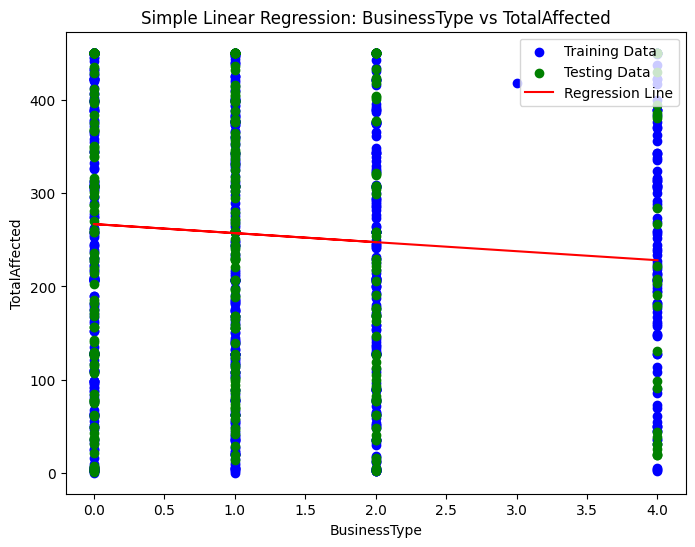

Column: BusinessSubType
Training R^2: 0.0000
Testing R^2: 0.0003
Training RMSE: 150.40
Testing RMSE: 152.42
Intercept: 256.16
Slope: -0.11


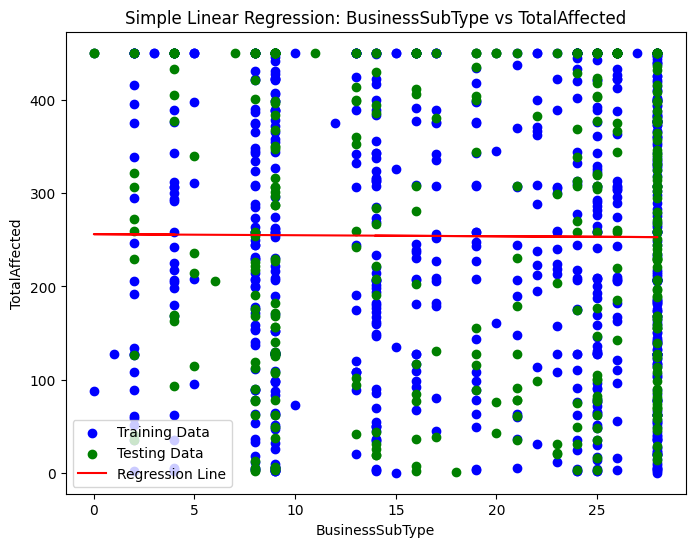

Column: BreachType
Training R^2: 0.0006
Testing R^2: -0.0024
Training RMSE: 150.36
Testing RMSE: 152.63
Intercept: 247.01
Slope: 0.28


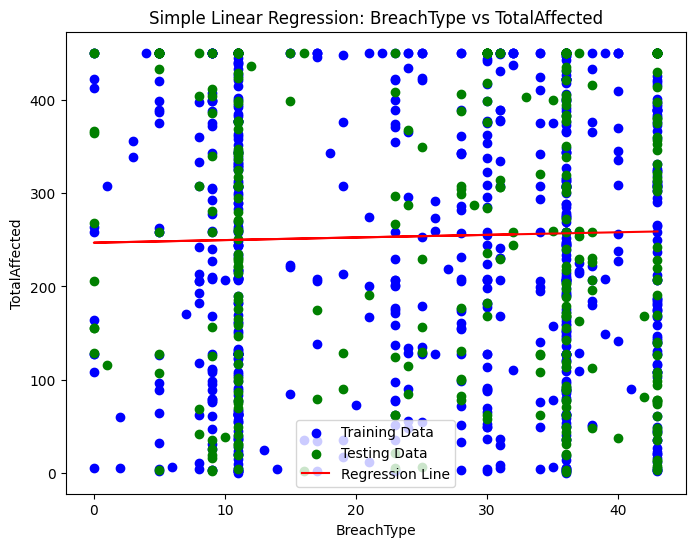

Column: DataType
Training R^2: 0.0051
Testing R^2: -0.0107
Training RMSE: 150.02
Testing RMSE: 153.26
Intercept: 280.45
Slope: -3.62


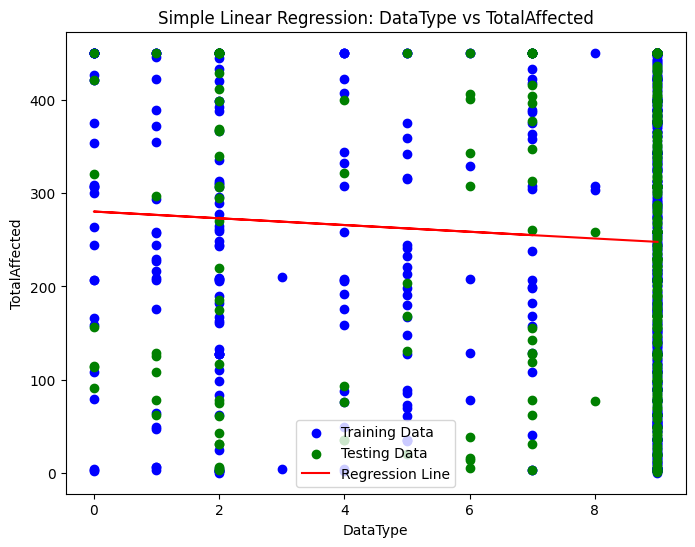

Column: DataType2
Training R^2: 0.0002
Testing R^2: 0.0011
Training RMSE: 150.38
Testing RMSE: 152.36
Intercept: 257.77
Slope: -0.60


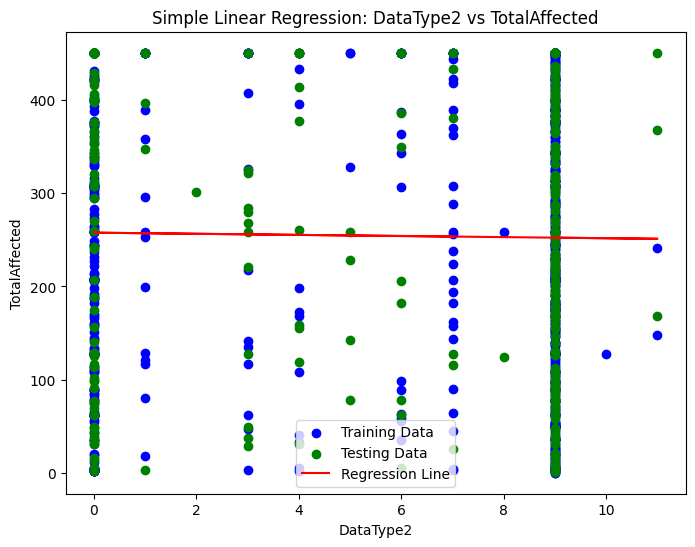

Column: InsideOutside
Training R^2: 0.0016
Testing R^2: -0.0064
Training RMSE: 150.29
Testing RMSE: 152.93
Intercept: 276.13
Slope: -3.60


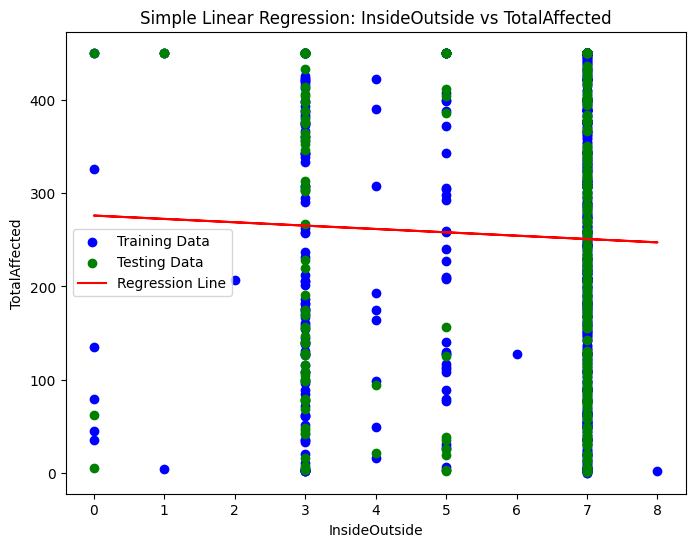

Column: ThirdParty
Training R^2: 0.0014
Testing R^2: 0.0014
Training RMSE: 150.29
Testing RMSE: 152.34
Intercept: 288.57
Slope: -16.27


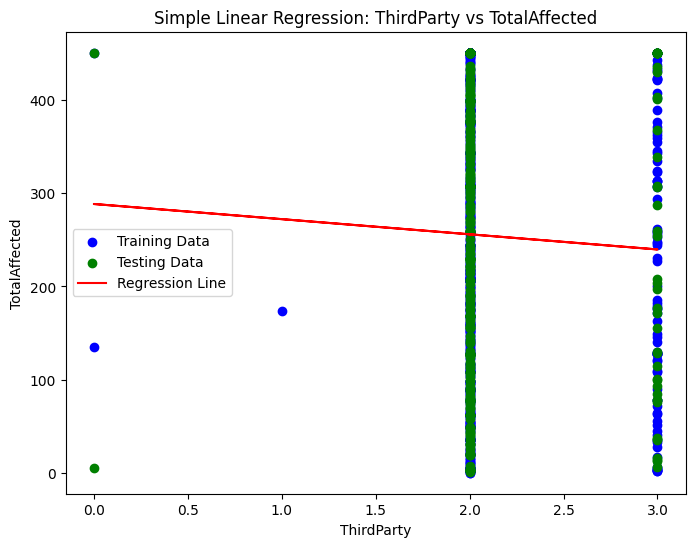

Column: ThirdPartyName
Training R^2: 0.0002
Testing R^2: 0.0002
Training RMSE: 150.39
Testing RMSE: 152.43
Intercept: 254.57
Slope: -0.12


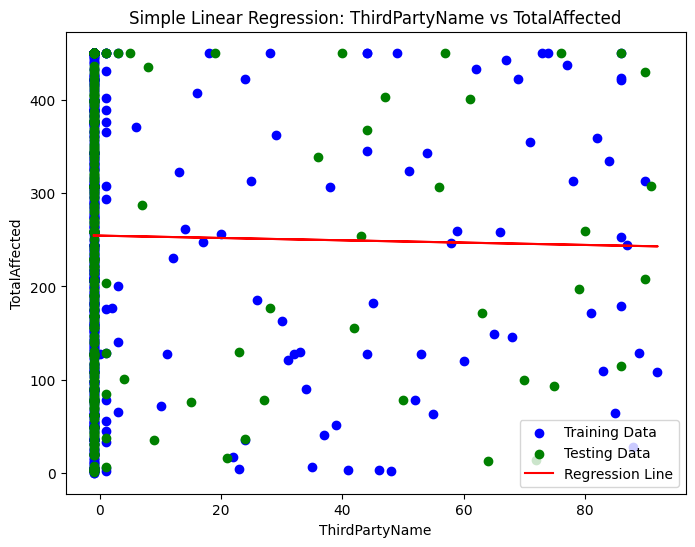

Column: DataRecovered
Training R^2: 0.0037
Testing R^2: -0.0092
Training RMSE: 150.12
Testing RMSE: 153.15
Intercept: 247.07
Slope: 8.81


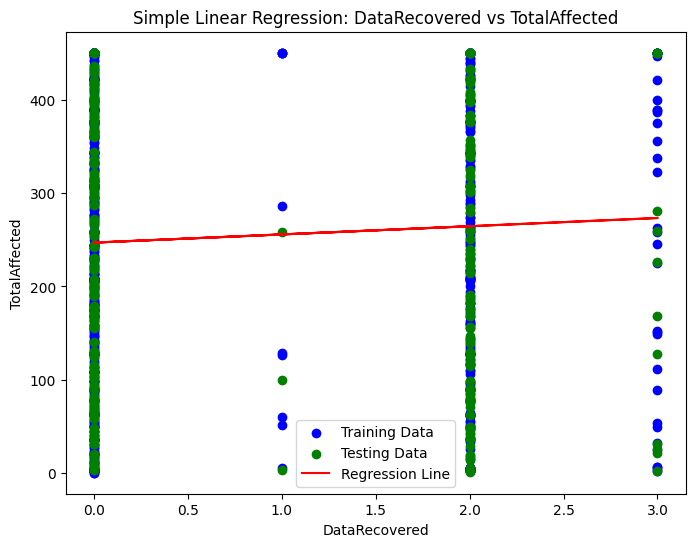

Column: ConsumerLawsuit
Training R^2: 0.0037
Testing R^2: -0.0148
Training RMSE: 150.12
Testing RMSE: 153.57
Intercept: 247.63
Slope: 17.31


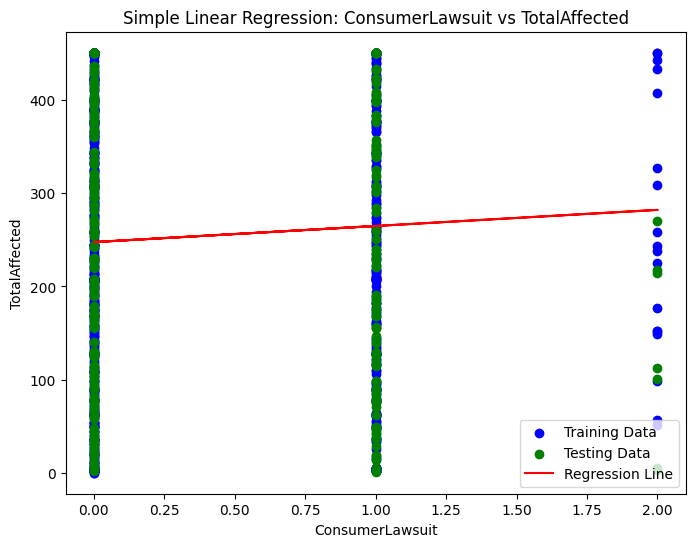

Column: ArrestProsecution
Training R^2: 0.0008
Testing R^2: -0.0041
Training RMSE: 150.34
Testing RMSE: 152.76
Intercept: 251.05
Slope: 7.22


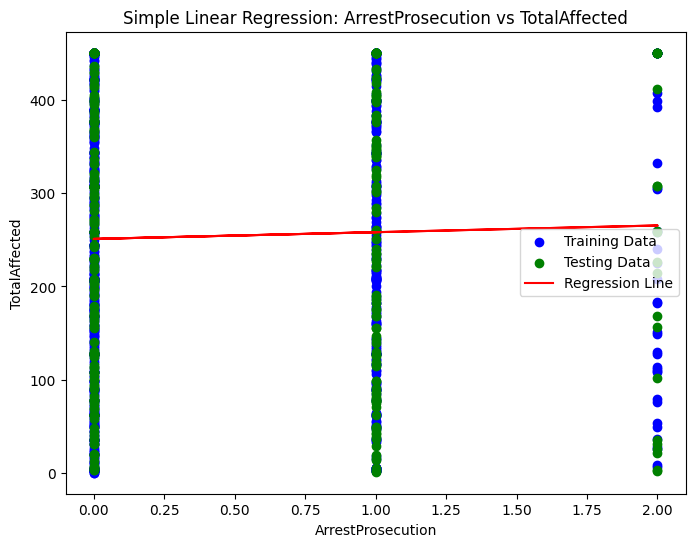

Column: Year
Training R^2: 0.0056
Testing R^2: -0.0103
Training RMSE: 149.98
Testing RMSE: 153.23
Intercept: 17551.58
Slope: -8.62


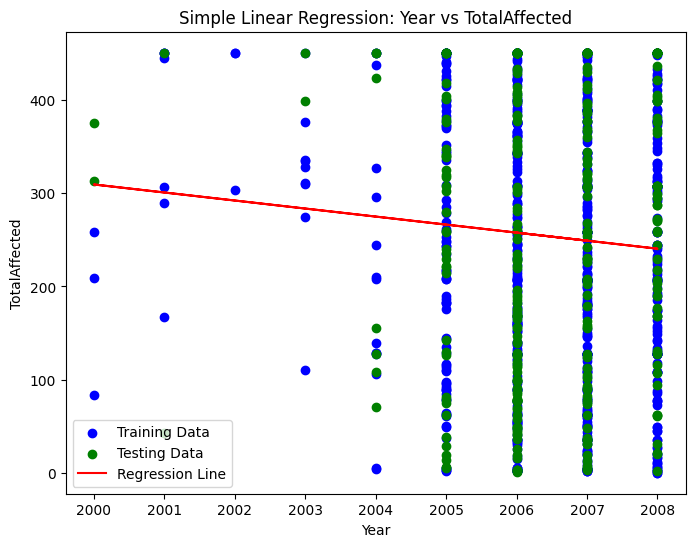

In [20]:
# Getting the column names except for the dependent variable column
independent_variables = df.drop('TotalAffected', axis=1).columns

for column in independent_variables:
    X = df[[column]]  # Independent variable
    y = df['TotalAffected']  # Dependent variable

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Creating and fitting the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict values
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculating R-squared
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Calculating root mean squared error (RMSE)
    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    # Intercept and slope of the regression line
    intercept = model.intercept_
    slope = model.coef_[0]

    # Printing the results
    print(f"Column: {column}")
    print(f"Training R^2: {train_r2:.4f}")
    print(f"Testing R^2: {test_r2:.4f}")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Testing RMSE: {test_rmse:.2f}")
    print(f"Intercept: {intercept:.2f}")
    print(f"Slope: {slope:.2f}")

    # Plotting the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train, y_train, color='blue', label='Training Data')
    plt.scatter(X_test, y_test, color='green', label='Testing Data')
    plt.plot(X_train, model.predict(X_train), color='red', label='Regression Line')
    plt.title(f'Simple Linear Regression: {column} vs TotalAffected')
    plt.xlabel(column)
    plt.ylabel('TotalAffected')
    plt.legend()
    plt.show()


| Column            | Testing R² | Testing RMSE |
|-------------------|------------|--------------|
| BusinessType      | 0.0094     | 151.73       |
| BusinessSubType   | 0.0003     | 152.42       |
| BreachType        | -0.0024    | 152.63       |
| DataType          | -0.0107    | 153.26       |
| DataType2         | 0.0011     | 152.36       |
| InsideOutside     | -0.0064    | 152.93       |
| ThirdParty        | 0.0014     | 152.34       |
| ThirdPartyName    | 0.0002     | 152.43       |
| DataRecovered     | -0.0092    | 153.15       |
| ConsumerLawsuit   | -0.0148    | 153.57       |
| ArrestProsecution | -0.0041    | 152.76       |
| Year              | -0.0103    | 153.23       |


The column with the highest testing R² value and relatively lower testing RMSE compared to others is 'BusinessType', with a testing R² of 0.0094 and a testing RMSE of 151.73. Hence, in this scenario, 'BusinessType' might be considered the best column among the listed columns for predicting the 'TotalAffected' variable. 







## Task 3: Multiple Linear Regression

### Objective

Conduct multiple linear regression and compare models.

### Entry Points

1. Choose multiple independent variables and the dependent variable.
2. Build a multiple linear regression model.
3. Calculate coefficients of determination, RMSE, intercept, and slope.
4. Predict values for training and test datasets.
5. Compare predicted vs. actual values and plot the results.
6. Determine the optimal number of columns for the model.
---


1. **Data Setup:**
    - Uses three columns ('BreachType', 'BusinessType') as predictors (X1, X2).
    - 'TotalAffected' is the predicted variable (y).

2. **Data Splitting:**
    - Splits data into training and testing sets (80-20 ratio).
    - `X_train`, `X_test`: Independent variables for training and testing.
    - `y_train`, `y_test`: Dependent variable for training and testing.

3. **Model Training:**
    - Builds a multiple linear regression model (`model_1`) using `LinearRegression()`.

4. **Predictions:**
    - Calculates predictions for both training and testing data: `y_pred_train_1` and `y_pred_test_1`.

5. **Performance Evaluation:**
    - Computes R-squared scores (`r2_train_1` and `r2_test_1`) and RMSE (`rmse_train_1` and `rmse_test_1`).
    - Assesses how well the model predicts 'TotalAffected' in both training and testing data.

6. **Visualization:**
    - Plots 'Actual' vs. 'Predicted' 'TotalAffected' values for the test set.
    - Shows how the model predictions compare to the actual values.

7. **Metrics and Coefficients:**
    - Prints R-squared scores, RMSE, intercept, and coefficients for the chosen columns.
    - Provides insights into the model's performance and how each predictor contributes to predicting 'TotalAffected'.

8. **Purpose:**
    - To understand how well the model estimates 'TotalAffected' based on the given three columns.
    - Assesses the model's accuracy on unseen data and showcases the relationship between predictors and the predicted variable.


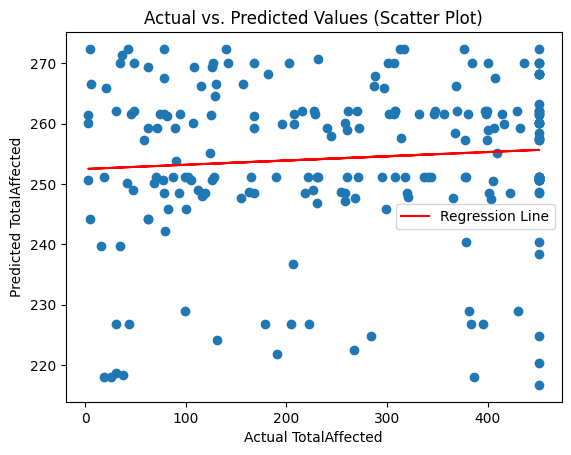

Metrics for X1 and X2:
Training R²: 0.0084
Testing R²: 0.0057
Training RMSE: 150.02
Testing RMSE: 151.96
Intercept: 258.465552442596
Coefficients: [  0.32431868 -10.85269808]


In [37]:
# Scenario 1: Two Columns (X1, X2)
X1X2 = df[['BreachType', 'BusinessType']]
y = df['TotalAffected']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1X2, y, test_size=0.2, random_state=42)

# Initialize and fit the multiple linear regression model
model_1 = LinearRegression()
model_1.fit(X_train, y_train)

# Make predictions
y_pred_train_1 = model_1.predict(X_train)
y_pred_test_1 = model_1.predict(X_test)

# Calculate metrics
r2_train_1 = r2_score(y_train, y_pred_train_1)
r2_test_1 = r2_score(y_test, y_pred_test_1)
rmse_train_1 = mean_squared_error(y_train, y_pred_train_1, squared=False)
rmse_test_1 = mean_squared_error(y_test, y_pred_test_1, squared=False)

plt.scatter(y_test.values, y_pred_test_1)
plt.xlabel('Actual TotalAffected')
plt.ylabel('Predicted TotalAffected')
plt.title('Actual vs. Predicted Values (Scatter Plot)')

# Fit a linear regression line
m, b = np.polyfit(y_test.values, y_pred_test_1, 1)  # Calculate slope (m) and y-intercept (b) for the regression line

# Plot the regression line
plt.plot(y_test.values, m * y_test.values + b, color='red', label='Regression Line')

plt.legend()
plt.show()
# Print metrics and model coefficients for X1 and X2
print("Metrics for X1 and X2:")
print(f"Training R²: {r2_train_1:.4f}")
print(f"Testing R²: {r2_test_1:.4f}")
print(f"Training RMSE: {rmse_train_1:.2f}")
print(f"Testing RMSE: {rmse_test_1:.2f}")
print(f"Intercept: {model_1.intercept_}")
print(f"Coefficients: {model_1.coef_}")



1. **Data Setup:**
    - Uses three columns ('BreachType', 'BusinessType', 'DataType') as predictors (X1, X2, X3).
    - 'TotalAffected' is the predicted variable (y).

2. **Data Splitting:**
    - Splits data into training and testing sets (80-20 ratio).
    - `X_train`, `X_test`: Independent variables for training and testing.
    - `y_train`, `y_test`: Dependent variable for training and testing.

3. **Model Training:**
    - Builds a multiple linear regression model (`model_2`) using `LinearRegression()`.

4. **Predictions:**
    - Calculates predictions for both training and testing data: `y_pred_train_2` and `y_pred_test_2`.

5. **Performance Evaluation:**
    - Computes R-squared scores (`r2_train_2` and `r2_test_2`) and RMSE (`rmse_train_2` and `rmse_test_2`).
    - Assesses how well the model predicts 'TotalAffected' in both training and testing data.

6. **Visualization:**
    - Plots 'Actual' vs. 'Predicted' 'TotalAffected' values for the test set.
    - Shows how the model predictions compare to the actual values.

7. **Metrics and Coefficients:**
    - Prints R-squared scores, RMSE, intercept, and coefficients for the chosen columns.
    - Provides insights into the model's performance and how each predictor contributes to predicting 'TotalAffected'.

8. **Purpose:**
    - To understand how well the model estimates 'TotalAffected' based on the given three columns.
    - Assesses the model's accuracy on unseen data and showcases the relationship between predictors and the predicted variable.


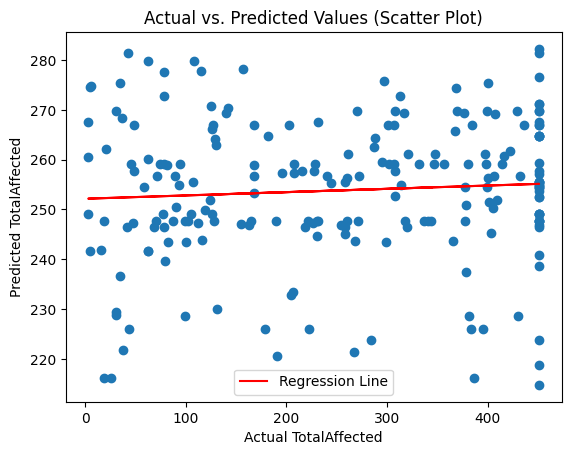

Metrics for X1, X2 and X3 :
Training R²: 0.0094
Testing R²: 0.0036
Training RMSE: 149.94
Testing RMSE: 152.12
Intercept: 269.1399921316256
Coefficients: [  0.36339158 -10.2079393   -1.70546392]


In [42]:
# Scenario 2: Three Columns (X1, X2, X3)
X1X2X3 = df[['BreachType', 'BusinessType','DataType']]
y = df['TotalAffected']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1X2X3, y, test_size=0.2, random_state=42)

# Initialize and fit the multiple linear regression model
model_2 = LinearRegression()
model_2.fit(X_train, y_train)

# Make predictions
y_pred_train_2 = model_2.predict(X_train)
y_pred_test_2 = model_2.predict(X_test)

# Calculate metrics
r2_train_2 = r2_score(y_train, y_pred_train_2)
r2_test_2 = r2_score(y_test, y_pred_test_2)
rmse_train_2 = mean_squared_error(y_train, y_pred_train_2, squared=False)
rmse_test_2 = mean_squared_error(y_test, y_pred_test_2, squared=False)

plt.scatter(y_test.values, y_pred_test_2)
plt.xlabel('Actual TotalAffected')
plt.ylabel('Predicted TotalAffected')
plt.title('Actual vs. Predicted Values (Scatter Plot)')

# Fit a linear regression line
m, b = np.polyfit(y_test.values, y_pred_test_2, 1)  # Calculate slope (m) and y-intercept (b) for the regression line

# Plot the regression line
plt.plot(y_test.values, m * y_test.values + b, color='red', label='Regression Line')

plt.legend()
plt.show()
# Print metrics and model coefficients for X1 and X2
print("Metrics for X1, X2 and X3 :")
print(f"Training R²: {r2_train_2:.4f}")
print(f"Testing R²: {r2_test_2:.4f}")
print(f"Training RMSE: {rmse_train_2:.2f}")
print(f"Testing RMSE: {rmse_test_2:.2f}")
print(f"Intercept: {model_2.intercept_}")
print(f"Coefficients: {model_2.coef_}")


## Task 4: Overfitting versus Underfitting

### Objective

Evaluate model performance with different training set sizes.

### Entry Points

1. Adjust the training set size and re-run the models.
2. Compare model performance using coefficients of determination and RMSE.
3. Discuss the attributes better for comparing LR models.

---


1. **Defining Parameters:**
    - Initializes empty lists (`train_r2_scores`, `test_r2_scores`, `train_rmse_scores`, `test_rmse_scores`) to store evaluation metrics.
    - `training_sizes`: Contains different proportions of training set sizes (50%, 60%, 70%, 80%, 90%).

2. **Model Evaluation Loop:**
    - Iterates through each training set size from `training_sizes`.
    - For each size:
        - Splits the data into training and testing sets using `train_test_split()` with the specified size.
        - Defines independent variables (X) and the dependent variable (y).

3. **Linear Regression Modeling:**
    - Creates and fits a Linear Regression model using `LinearRegression()` from `sklearn.linear_model`.
    - Predicts values for both training and test sets.

4. **Performance Metrics Calculation:**
    - Computes R-squared scores (`train_r2` and `test_r2`) using `r2_score()` from `sklearn.metrics`.
    - Calculates Root Mean Squared Error (RMSE) (`train_rmse` and `test_rmse`) using `mean_squared_error()`.

5. **Storing Evaluation Scores:**
    - Appends R-squared scores and RMSE values to respective lists for both training and test sets.

6. **Output:**
    - Prints the lists containing R-squared scores and RMSE values for training and test sets, respectively.

7. **Purpose:**
    - To observe how the performance metrics (R-squared and RMSE) of a Linear Regression model change with varying training set sizes.
    - Provides insights into how the model generalizes to unseen data when trained on different proportions of the dataset.

In [23]:
train_r2_scores = []
test_r2_scores = []
train_rmse_scores = []
test_rmse_scores = []

# Varying training set sizes
training_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

for size in training_sizes:
    # Splitting the data into training and testing sets with varying sizes
    X = df[['BusinessType']]
    y = df['TotalAffected']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=42)

    # Creating and fitting the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict values
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculating R-squared
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Calculating root mean squared error (RMSE)
    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

    # Appending scores to lists
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)

print(train_r2_scores)
print(test_r2_scores)
print(train_rmse_scores)
print(test_rmse_scores)

[0.006558409688396272, 0.008103391714228136, 0.00698339177502838, 0.007562215969232566, 0.009594193582545985]
[0.006557400086402487, 0.006561298638962265, 0.009410745897097006, 0.007398132153949466, -0.008777056695489227]
[150.7173694668785, 150.05327942271632, 149.8762184046359, 150.0775769690708, 150.21617534022354]
[150.23843908340555, 151.0083431561074, 151.72629953224475, 151.8340722541079, 152.37415125114606]


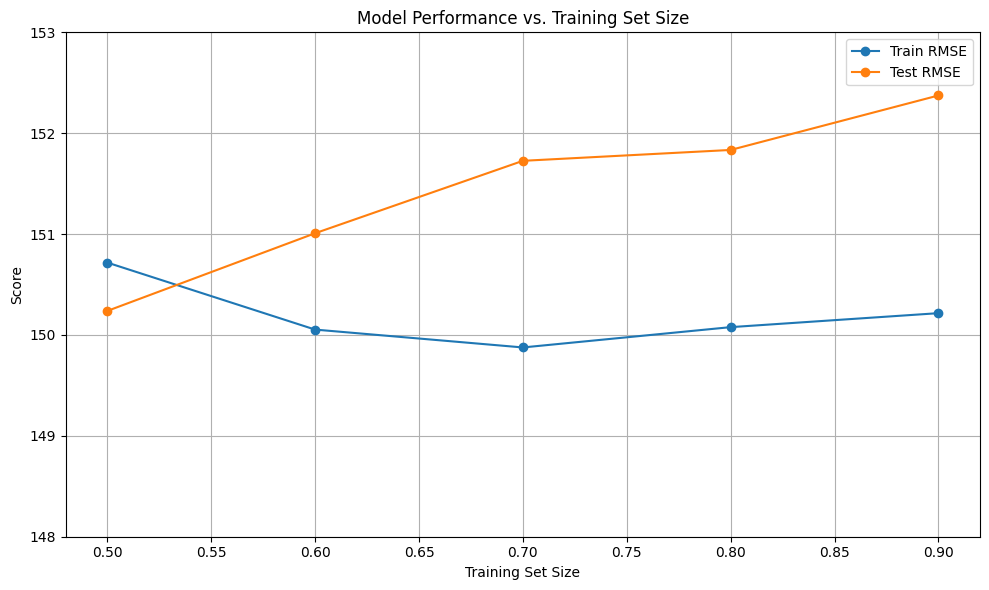

In [24]:
plt.figure(figsize=(10, 6))
# Plotting RMSE scores
plt.plot(training_sizes, train_rmse_scores, marker='o', linestyle='-', label='Train RMSE')
plt.plot(training_sizes, test_rmse_scores, marker='o', linestyle='-', label='Test RMSE')
plt.title('Model Performance vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.ylim(0, 2)
plt.ylim(148, 153)
plt.tight_layout()

plt.show()


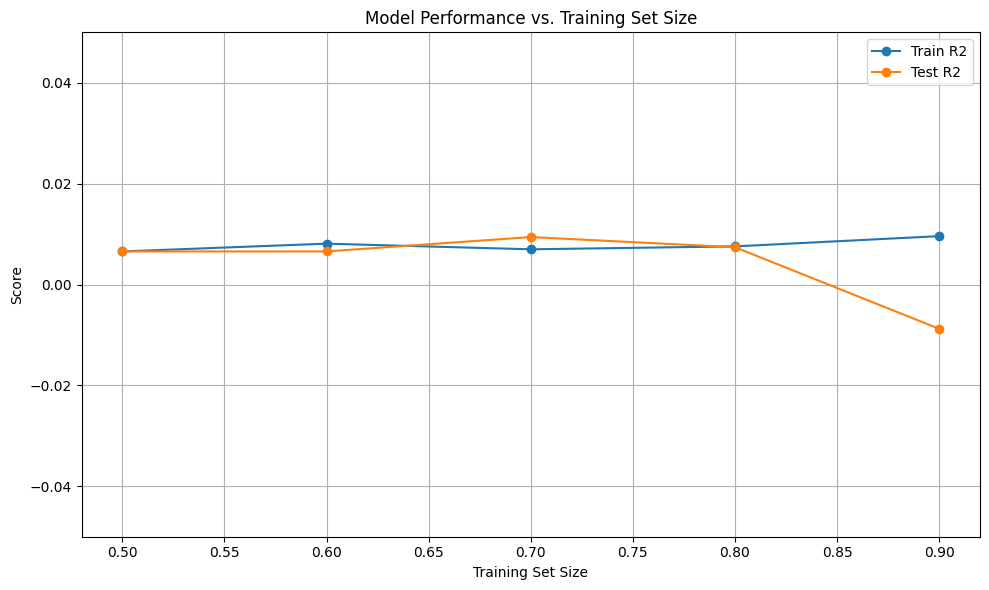

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_r2_scores, marker='o', linestyle='-', label='Train R2')
plt.plot(training_sizes, test_r2_scores, marker='o', linestyle='-', label='Test R2')
plt.title('Model Performance vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.ylim(-0.05, 0.05)
plt.tight_layout()
plt.show()


The code snippet demonstrates the use of k-fold cross-validation to evaluate the performance of a Linear Regression model with varying numbers of folds.

1. **Varying Folds:**
    - The code iterates through different numbers of folds: 3, 5, 7, 10, and 12.
  
2. **Cross-Validation Process:**
    - For each specified number of folds:
        - Divides the data into 'k' folds using `KFold` from `sklearn.model_selection`.
        - Trains a Linear Regression model on 'k-1' folds and validates on the remaining fold.
        - Calculates R-squared and RMSE for each fold, storing these metrics for evaluation.
        
3. **Performance Evaluation:**
    - Computes the average R-squared and RMSE across all folds using NumPy's `np.mean()` function.
    - Outputs the average R-squared and RMSE for each number of folds.

4. **Purpose:**
    - Helps assess how the model's performance varies with different numbers of folds.
    - Aids in understanding the model's stability and generalization capabilities.

5. **Output:**
    - The printed results display the average R-squared and RMSE for each number of folds, guiding in choosing an optimal number of folds for cross-validation based on model performance.


Number of Folds: 3
Average R-squared: 0.0053
Average RMSE: 150.50
--------------------------
Number of Folds: 4
Average R-squared: -0.0007
Average RMSE: 150.63
--------------------------
Number of Folds: 5
Average R-squared: 0.0035
Average RMSE: 150.52
--------------------------
Number of Folds: 6
Average R-squared: 0.0053
Average RMSE: 150.47
--------------------------
Number of Folds: 7
Average R-squared: 0.0024
Average RMSE: 150.47
--------------------------
Number of Folds: 8
Average R-squared: -0.0040
Average RMSE: 150.59
--------------------------
Number of Folds: 9
Average R-squared: -0.0108
Average RMSE: 150.64
--------------------------
Number of Folds: 10
Average R-squared: 0.0021
Average RMSE: 150.46
--------------------------
Number of Folds: 11
Average R-squared: 0.0012
Average RMSE: 150.51
--------------------------
Number of Folds: 12
Average R-squared: -0.0018
Average RMSE: 150.51
--------------------------


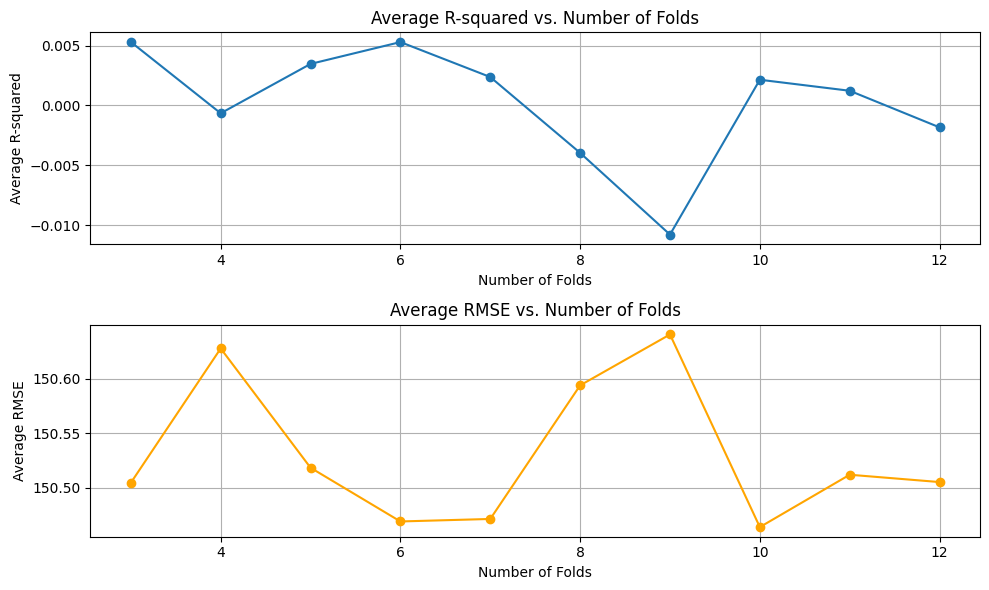

In [26]:
# Varying number of folds
num_folds_list = list(range(3, 13))

r2_values = []
rmse_values = []

for num_folds in num_folds_list:
    kf = KFold(n_splits=num_folds)
    
    r2_scores = []
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        r2 = model.score(X_val, y_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        r2_scores.append(r2)
        rmse_scores.append(rmse)

    average_r2 = np.mean(r2_scores)
    average_rmse = np.mean(rmse_scores)

    r2_values.append(average_r2)
    rmse_values.append(average_rmse)

    print(f'Number of Folds: {num_folds}')
    print(f'Average R-squared: {average_r2:.4f}')
    print(f'Average RMSE: {average_rmse:.2f}')
    print('--------------------------')

# Plotting the graph
plt.figure(figsize=(10, 6))

# Plotting R-squared values
plt.subplot(2, 1, 1)
plt.plot(num_folds_list, r2_values, marker='o', linestyle='-')
plt.title('Average R-squared vs. Number of Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Average R-squared')
plt.grid(True)

# Plotting RMSE values
plt.subplot(2, 1, 2)
plt.plot(num_folds_list, rmse_values, marker='o', linestyle='-', color='orange')
plt.title('Average RMSE vs. Number of Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Average RMSE')
plt.grid(True)

plt.tight_layout()
plt.show()